In [1]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
import gzip
from tqdm import tqdm_notebook
from functools import reduce

In [3]:
idx = pd.IndexSlice
rc = ipp.Client()#('/home/julian/.ipython/profile_ssh/security/ipcontroller-client.json')
dview = rc.load_balanced_view()
print(rc.ids)
sns.set_style("whitegrid")

def send_file(dview, local_path, remote_path):
    """Send a single file"""
    print("sending file", local_path, remote_path)
    import io, os
    
    def _recv(remote_path, bdata, mtime):
        import io, os
        if os.path.exists(remote_path):
            os.unlink(remote_path)
        with io.open(remote_path, 'wb') as f:
            f.write(data)
        os.utime(remote_path, (mtime, mtime))
    
    st = os.stat(local_path)
    with io.open(local_path, 'rb') as f:
        data = f.read()
    
    yield dview.apply_async(_recv, remote_path, data, st.st_mtime)
    
#TODO: use chrpath PyVal.so -r . to make libtrng visible
#for el in send_file(dview, '../build/PyVal.cpython-36m-x86_64-linux-gnu.so','./PyVal.so'):
    
    print(el.get())
for el in send_file(dview, '../external/lib/libtrng4.so.19', './libtrng4.so.19'):
    pass
for el in send_file(dview, '../external/lib/libtrng4.so', './libtrng4.so'):
    pass

with rc[:].sync_imports():
    import PyVal
    import numpy as np


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
sending file ../external/lib/libtrng4.so.19 ./libtrng4.so.19
None
sending file ../external/lib/libtrng4.so ./libtrng4.so
None
importing PyVal on engine(s)
importing numpy on engine(s)


In [22]:
df_test.loc[10]['Delta']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02532506, 0.0152955 , 0.02048212, ..., 1.01120598, 0.0274391 ,
        0.02552286],
       [0.01859017, 0.01730288, 0.01685424, ..., 0.01979983, 1.01315256,
        0.02571617],
       [0.01712194, 0.02182064, 0.01468877, ..., 0.0201252 , 0.02042664,
        1.01368067]])

In [4]:
#@ipp.require('PyVal', 'numpy')
indices = ['S0','T', 'r', 'N', 'col sum', 'default scale', 'conn']
col_names = ['M', 'Assets', 'RS', 'Delta', 'Vega', 'Theta', 'Rho', 'Pi', 'Solvent']
tmp_cols = ['N_MC', 'N_nets', 'Number Of Samples', 'p']

def reduce_to_scalars(df, N, conn_scale):
    #cols = df.columns.values
    #cols = np.delete(cols, np.where((cols == 'RS') | (cols == 'Delta') | (cols == 'Delta var') | (cols == 'Vega') |\
    #                            (cols == 'Vega') | (cols == 'Vega var') | (cols == 'Rho') | (cols == 'Rho var') |\
    #                            (cols == 'Theta') | (cols == 'Theta var') | (cols == 'Pi') | (cols == 'Pi var') |\
    #                            (cols == 'M') | (cols == 'M var') | (cols == 'N_MC') | (cols == 'N_nets') |\
    #                            (cols == 'col sum') ))
    cols =  np.array(['N', 'r', 'T', 'conn', 'default scale', 'col sum', 'S0' \
                      'Solvent', 'Solvent var', 'Assets', 'Assets var', 'R', 'S', \
                      'equity Delta', 'equity Delta var', 'debt Delta', 'debt Delta var',\
                      'equity Vega', 'equity Vega var', 'debt Vega', 'debt Vega var',\
                      'equity Rho', 'equity Rho var', 'debt Rho', 'debt Rho var',\
                      'equity Theta', 'equity Theta var', 'debt Theta', 'debt Theta var',\
                      'equity Pi', 'equity Pi var', 'debt Pi', 'debt Pi var',\
                      'equity col sum', 'debt col sum', 'equity row sum', 'debt row sum'])
    df2 = pd.DataFrame(columns = cols, dtype=np.float64)
    df2['conn'] = df['conn'].transform(lambda x: x/conn_scale)
    df2['Number Of Samples'] = df['Number Of Samples'].transform(lambda x: x[1])
    df2['S'] = df['RS'].transform(lambda x: np.average(x[:N]))
    df2['R'] = df['RS'].transform(lambda x: np.average(x[N:]))
    for el in ['Delta', 'Vega', 'Rho', 'Theta', 'Pi']:
        df2['equity ' + el] = df[el].transform(lambda x: np.sum(x[:N,:])/N)
        df2['equity ' +el+ ' var'] = df[el+' var'].transform(lambda x: np.sum(x[:N,:])/N)
        df2['debt ' + el] = df[el].transform(lambda x: np.sum(x[N:,:])/N)
        df2['debt ' +el+' var'] = df[el+' var'].transform(lambda x: np.sum(x[N:,:])/N)
    df2['equity col sum'] = df['M'].transform(lambda x: np.average(np.sum(x[:,:N], axis=0)))
    df2['debt col sum']   = df['M'].transform(lambda x: np.average(np.sum(x[:,N:], axis=0)))
    df2['equity row sum'] = df['M'].transform(lambda x: np.average(np.sum(x[:,:N], axis=1)))
    df2['debt row sum']   = df['M'].transform(lambda x: np.average(np.sum(x[:,N:], axis=1)))
    df2['Assets'] = df['Assets'].transform(lambda x: np.average(x))
    df2['Assets var'] = df['Assets var'].transform(lambda x: np.average(x))
    df2['Solvent'] = df['Solvent'].transform(lambda x: np.average(x))
    df2['Solvent var'] = df['Solvent var'].transform(lambda x: np.average(x))
    df2['N'] = df['N']
    df2['r'] = df['r']
    df2['T'] = df['T']
    df2['S0'] = df['S0']
    df2['col sum'] = df['col sum']
    #df2['p'] = df['p']
    df2['default scale'] = df['default scale']
    return df2

def reduce_to_scalars_old(df, conn_scale):
    for ix in df.index:
        for ind in df.loc[ix].index:
            N = int(df.loc[ix,'N'])
            if ind == 'conn':
                df.loc[ix, ind] = df.loc[ix, ind]/conn_scale
            elif ind == 'Number Of Samples':
                df.loc[ix, ind] = df.loc[ix, ind][1]
            elif ind == 'RS':
                df.loc[ix, 'S'] = np.average(df.loc[ix, ind][:N])
                df.loc[ix, 'R'] = np.average(df.loc[ix, ind][N:])
                #df.loc[ix, 'R'] = df.loc[ix, ind]
            elif ind == 'Delta' or ind == 'Delta var' or ind == 'Vega' or ind == 'Vega var':
                df.loc[ix, ind] = np.sum(df.loc[ix, ind])/N
            elif ind == 'Rho'or ind == 'Theta' or ind == 'Pi' or ind == 'Rho var' or ind == 'Theta var' or ind == 'Pi var':
                df.loc[ix,"equity " + ind] = np.average(df.loc[ix, ind][:N])
                df.loc[ix,"debt " + ind] = np.average(df.loc[ix, ind][N:])
            elif ind == 'M' or ind == 'M var':
                df.loc[ix, 'avg col sum'] = np.average(np.sum(df.loc[ix, ind][:,N:], axis=0))
                df.loc[ix, 'avg row sum'] = np.average(np.sum(df.loc[ix, ind], axis=1))
                df.loc[ix, ind] = np.sum(df.loc[ix, ind])/N
            else:
                df.loc[ix, ind] = np.average(df.loc[ix, ind])
    df.drop(columns='RS', inplace=True)
    df.drop(columns='Delta', inplace=True)
    df.drop(columns='Delta var', inplace=True)
    df.drop(columns='Vega', inplace=True)
    df.drop(columns='Vega var', inplace=True)
    df.drop(columns='Rho', inplace=True)
    df.drop(columns='Rho var', inplace=True)
    df.drop(columns='Theta', inplace=True)
    df.drop(columns='Theta var', inplace=True)
    df.drop(columns='Pi', inplace=True)
    df.drop(columns='Pi var', inplace=True)
    df.drop(columns='M', inplace=True)
    df.drop(columns='M var', inplace=True)
    

def run_sim(N, row_val, col_val, p, T, r, S0, default_scale):
    import numpy as np
    mul = max(1,col_val+S0)
    N_MC = 5#int(400*mul)    # 600
    N_nets = 10#int(800*mul)  # 1100
    nw = PyVal.BS_Network()
    print("Runing N=" +str(N)+", col sum="+str(col_val)+", p="+str(p))
    nw.run(N, p, row_val, col_val, 2, T, r, S0, N_MC,  N_nets, default_scale)
    k_list = nw.k_vals()[0]
    res = []
    for k in k_list:
        res.append({'N': N, 'Number Of Samples': nw.get_N_samples(k)[0], 'default scale': default_scale,\
               'conn': k, 'col sum': col_val, 'T':T, 'r': r ,'p': p, 'S0': S0, \
               'M': nw.get_M(k), 'M var': nw.get_M_var(k),\
               'Assets': np.array(nw.get_assets(k))[0], 'Assets var': np.array(nw.get_assets_var(k))[0],\
               'RS': np.array(nw.get_rs(k))[0],  'RS var': np.array(nw.get_rs_var(k))[0],\
               'Delta': nw.get_delta_jacobians(k),  'Delta var': nw.get_delta_jacobians_var(k),\
               'Vega': np.array(nw.get_vega(k)),  'Vega var': np.array(nw.get_vega_var(k)),\
               'Theta': np.array(nw.get_theta(k)),  'Theta var': np.array(nw.get_theta_var(k)),\
               'Rho': np.array(nw.get_rho(k)),  'Rho var': np.array(nw.get_rho_var(k)),\
               'Solvent': np.array(nw.get_solvent(k)), 'Solvent var': np.array(nw.get_solvent_var(k)),\
               'Pi': np.array(nw.get_pi(k)),  'Pi var': np.array(nw.get_pi_var(k))\
                   })
    return res

def combine_2_results(dict1, dict2):
    import copy
    res = copy.deepcopy(dict1)
    for k in tmp_cols:
        if k in res:
            res.pop(k)
    index_ok = True
    for ind in indices:
        if dict1[ind] != dict2[ind]:
            index_ok = False
    if index_ok:
        res['Number Of Samples'] = dict1['Number Of Samples'] + dict2['Number Of Samples']
        n1 = dict1['Number Of Samples'][1]
        n2 = dict2['Number Of Samples'][1]
        n_tot = n1 + n2
        for el in col_names:
            elv = el + ' var'
            res[el] = (n1*dict1[el] + n2*dict2[el])/n_tot
            res[elv] = (n1*(dict1[elv] + dict1[el]*dict1[el]) + n2*(dict2[elv] + dict2[el]*dict2[el]))/n_tot - res[el]*res[el]
        return [res]
    else:
        return [dict1, dict2]

    
def results_to_df(results):
    import copy
    candidates = {}
    df_list = []
    for r_list in results:
        for res in r_list:
            key = tuple([res[ind] for ind in indices])
            if key in candidates:
                candidates[key].append(res)
            else:
                candidates[key] = [res]
    for key, value in candidates.items():
        res_in = copy.deepcopy(value)
        while len(res_in) > 1:
            el1 = res_in.pop()
            el2 = res_in.pop()
            res_in = res_in + combine_2_results(el1, el2)
        candidates[key] = res_in[0]
        df_list.append(res_in[0])
    #res.set_index(indices, inplace=True)
    return pd.DataFrame(df_list)
        
            
    
def flatten_input(cell):
    if type(cell) is list:
        return cell[0]
    else:
        return cell

def pList(N, pts):
    import numpy as np
    #    return np.union1d(np.union1d(np.linspace(0.0, 10.0/N, pts), np.linspace(0.6/N,1.4/N,pts)), np.linspace((np.log(N)-np.log(N)/7.)/N,(np.log(N)+np.log(N)/7.)/N,pts))
    res = np.union1d(np.linspace(0.0, 2.0/N, 2*pts), np.union1d(np.linspace(0.0, 8.0/N, pts), np.linspace((np.log(N)-np.log(N)/7.)/N, (np.log(N)+np.log(N)/7.)/N, pts)))
    res = res[res <= 5.0/N]
    return res

def pFixedList(N, pts):
    import numpy as np
    return np.linspace(0.0, (pts-1)/N, pts)

# Parameters
## Black Scholes
    - T = 1
    - r = 0
    
## Network Parameters
    - N = [15, 25, 50, 75, 100, 150, 200, 300]
    - <k> = n*p = [0 .. 1.8]
    - M => ER(N,p)

In [15]:
tmp_res=run_sim(*param_grid[500])

Runing N=80, col sum=0.6249999999999999, p=0.05548670089359785


In [17]:
df_test = results_to_df([tmp_res])
df2_test = reduce_to_scalars(df_test, 80, 10.)

In [6]:
dview.block=False
Nlist = [80]
NPoints = 12
batch = 1
#default_scales_full = np.linspace(0.7,1.1,5)
default_scales = [1.0]# default_scales_full#[:5]
row_vals_all = np.linspace(0.1,0.7, 25)   #[0.1, 0.2, 0.4, 0.7]
row_vals = row_vals_all[batch::5]
S0_vals = np.linspace(0.25, 1.3, 25)
r_vals = [0.0]#[0.0, 0.05, 0.1]
T_vals = [1.0]
param_grid = [(N, row_sum, row_sum, el, T, r, S0, default_scale) for N in Nlist[::-1] for el in pList(N,NPoints)[::-1] for row_sum in row_vals[::-1] 
              for default_scale in default_scales for r in r_vals for T in T_vals for S0 in S0_vals]
len(param_grid)

5125

In [7]:
async_res = []
ids = []
for el in param_grid:
    with dview.temp_flags(retries=2):
        b_re = dview.apply_async(run_sim, *el)
        async_res.append(b_re)
        ids.extend(b_re.msg_ids)
filename = "param_grid_ER_10x_s0_vs_w_r0__batch1"

In [13]:
done = 0
waiting = 0
for el in async_res:
    if el.progress == 1:
        done += 1
    else:
        waiting += 1
print(str(done) + "/"+str(waiting+done) + " complete")
#param_grid_ER_no_suppression

39/5125 complete


In [14]:
print('unfinished jobs: '+ str(len(rc.result_status(ids)['pending'])) + '/' + str(len(rc.result_status(ids)['completed']) + len(rc.result_status(ids)['pending'])) + str('. Running on ') + str(len(rc.ids)) + ' nodes')

unfinished jobs: 5085/5125. Running on 128 nodes


In [199]:
f_content = [r.get() for r in async_res]
df = results_to_df(f_content)
df2 = reduce_to_scalars(df, 80, 10.)
df2.to_csv(filename+'.csv', index=False)
#df.set_index(indices,inplace=True)

# Plots

In [12]:
#inf = open('param_grid_ER_5x_ds_vs_w.pkl', 'rb') #'res_0_1_newnew.pkl'
df1 = pd.read_csv(filename+'.csv')
df_scales = np.unique(df1['default scale'])
col_sums = np.unique(df1['col sum'])  
spot_prices = np.unique(df1['S0'])    
df1.set_index(['N', 'conn', 'col sum', 'default scale', 'r', 'S0'], inplace=True)
spot_prices
#df1.reset_index([0,2,3]).index.values

FileNotFoundError: File b'param_grid_ER_10x_s0_vs_w_r0__batch1.csv' does not exist

In [11]:
df1.head()

NameError: name 'df1' is not defined

In [176]:
N = 80
val = 0.1
ds = 1.0
r = 0.0
S0 = 0.25
data = df3.loc[idx[N,:,val, ds, r, S0],['equity Delta','equity Delta var','debt Delta','debt Delta var', 'Number Of Samples']]

/home/jstobbe/ipcluster_1/ipcluster_1/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


<IPython.core.display.Javascript object>


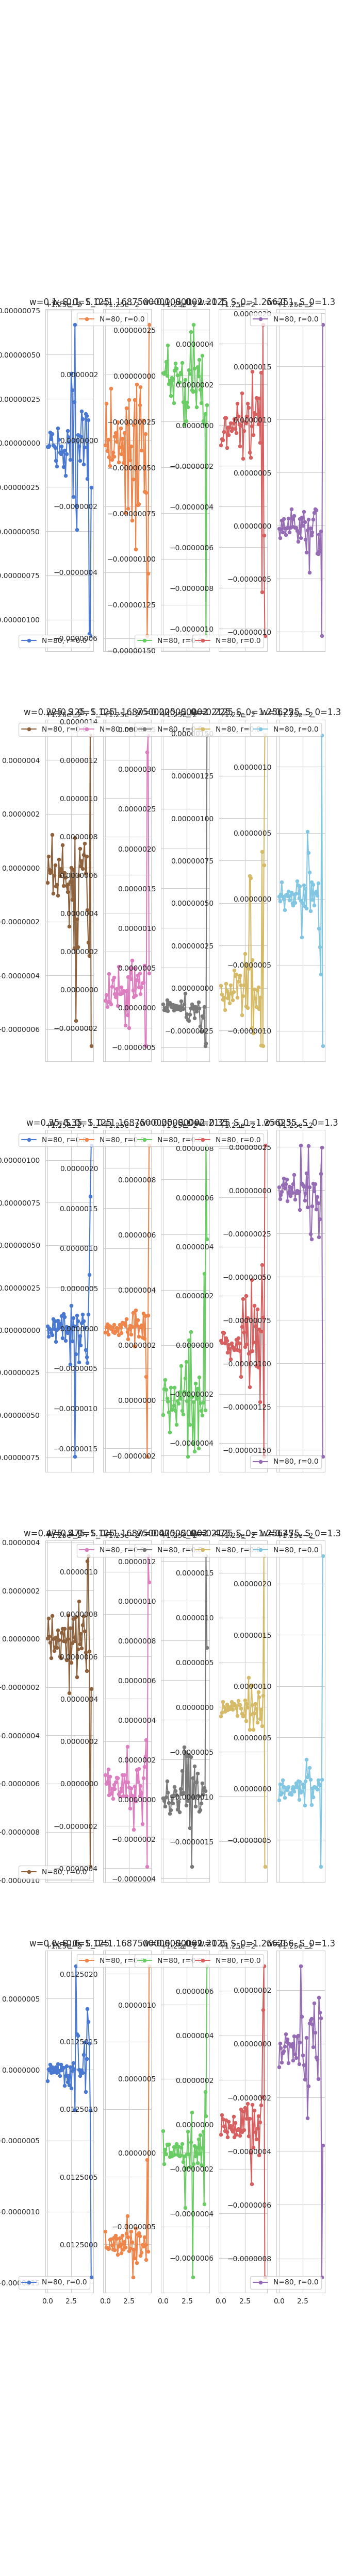

In [212]:
sns.set_style("whitegrid")
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)

def plot_val(l, ax, val, ds, S0 , title=""):
    nl = np.unique(l.reset_index(level=[1,2,3,4,5]).index.values)
    rl = np.unique(df1.reset_index()['r'])
    for r in rl:
        for N in nl:
            c = next(ccycle)
            data = l.loc[idx[N,:,val, ds, r, S0],['equity Delta','equity Delta var','debt Delta',\
                                                  'debt Delta var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Vega','Vega var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Solvent', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['RS', 'Number Of Samples']]
            n_samples = np.sqrt(np.array([ el for el in data['Number Of Samples'].values]))
            x = l.loc[idx[N,:,val, ds, r, S0],:].reset_index([0,2,3,4,5]).index.values
            y = np.array([np.sum(el)/(float(N)) for el in data['equity Delta'].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Delta var'].values])/n_samples
            #y = np.array([np.sum(el[:N]+el[N:])/(float(N)) for el in data['RS'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Solvent'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Vega'].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Vega var'].values])/n_samples
            ii = np.argsort(x)
            x = x[ii]
            y = y[ii]
            #y_err = y_err[ii]
            #sns.lineplot(x,y, ax = ax)
            ax.plot(x,y, marker='o', markersize=4.4, label="N="+str(N)+", r="+str(r),color=c)
            #ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
            if title:
                ax.set_title(title)
            else:
                ax.set_title(r'$\sum_j M_{ij} = $' + str(val) +" default scale " +str(ds))
            ax.legend()

       
fig, axs = plt.subplots(nrows=len(col_sums), ncols=len(spot_prices[:5]), sharex=True, sharey=False, figsize=(7*len(df_scales), 10*len(col_sums)))
for ic, val in enumerate(col_sums):
    for ir, sp in enumerate(spot_prices[20:]):
        ax = axs[ic,ir]
        plot_val(df1 ,ax, val, 1.0, sp, "w=" + str(val) + ", S_0=" + str(sp))

#axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#plt.errorbar(x, y, yerr=y_err, fmt='o')

plt.show()

In [175]:
len(spot_prices)

1

In [189]:
np.unique(df1.reset_index([0,1,2,3,4,5])['col sum'])   #r, S0, default scale, col sum

array([0.1, 0.3, 0.5, 0.7])

In [ ]:
#res = [r.get() for r in async_res]
results = []
res = res_0_4
tmp = combine_results(*res)
results.append(tmp[0])
while len(tmp[1]):
    tmp = combine_results(*tmp[1])
    results.append(tmp[0])
results[1]